In [1]:
import warnings

warnings.filterwarnings("ignore")
from exceedance_curve_tools import utils

from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.constants import CMAP_IMPACT
from climada.util.plot import plot_from_gdf
import numpy as np
import matplotlib.pyplot as plt

client = Client()
haz_tc_haiti = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
haz_tc_haiti.check()

# prepare exposure
from climada.util.api_client import Client
client = Client()


exposure = client.get_litpop(country="Haiti")
exposure.check()
exposure.data = exposure.data.loc[0:0]

# prepare impact function

impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

2025-08-20 15:29:11,884 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.


In [2]:
# compute impact and exceedance curve

impact = ImpactCalc(exposure, impf_set, haz_tc_haiti).impact(save_mat=True)

test_return_periods = np.geomspace(.01, 500, 100)

# compare stepfunction and extrapolate constant
values = [0,0]
for i, method in enumerate(["extrapolate_constant", "stepfunction"]):
    local_exceedance_intensity, label, title = impact.local_exceedance_impact(
        return_periods=test_return_periods, method=method, #method="extrapolate" method="extrapolate_constant"
    )
    values[i] = local_exceedance_intensity.iloc[0][1:].values



## Estimating expected annual impact from exceedance frequency curves

While in principle possible, there are a number of difficulties when estimating the average annual impact from an exceedance impact curve:

The exceedance impact curve data might be based on different return periods that the one stemming from the proabibilistic event sets. This leads to sightly different numbers, especially depending on the used interpolation method between data points (e.g., stepfunction rather underestimates, interpolate rather overestimates). These differences can eventually add up to quite a difference in final AAI.



In [3]:

# via impact matrix
print("probabilistic event set approach: ", impact.eai_exp[0])

# via local exceednace impact
# test_vals = local_exceedance_intensity.iloc[0][1:].values
exf = 1/test_return_periods

freqs = utils.frequency_from_exceedance_frequency(exf)

print("over exceedance impact curve with interpoaltion: ",np.nansum(freqs*values[0]))
print("over exceedance impact curve with stepfunction: ",np.nansum(freqs*values[1]))


probabilistic event set approach:  3515.056864705773
over exceedance impact curve with interpoaltion:  3552.4192570235555
over exceedance impact curve with stepfunction:  3317.082802953598


Text(0, 0.5, 'impact')

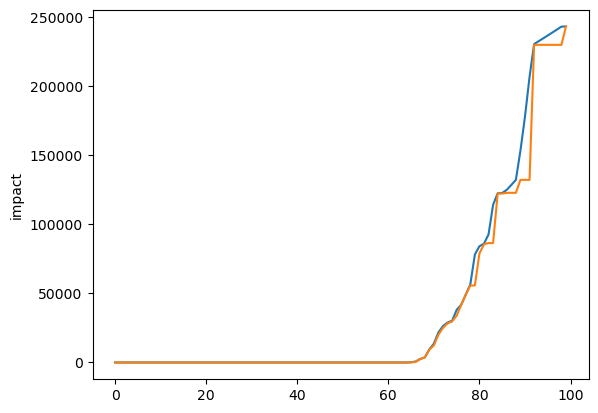

In [4]:
plt.plot(values[0], label="extrapolate_constant")
plt.plot(values[1], label="stepfunction")
plt.ylabel("impact")

When computing on probabilities instead of frequencies, a further difficulty arises: If one, e.g., computes the probability of the maximum impact per year being in a certain interval, and then computes the expectation values, one misses year with several impacts ocurring. This can be handled by computing the probabilities on a sufficiently small time window such that the probability of two impacts occuring at the same time is negligible.

In [5]:
print("frequencies: ",np.nansum(freqs*values[0]))
for cf, label in zip([1, 1/365.], ["yearly", "daily"]):
    probs = utils.prob_from_exceedance_frequency(exf, coincidence_fraction=cf)[1:]
    print(f"compute {label} probability: ", np.nansum(probs*values[0])/cf)


frequencies:  3552.4192570235555
compute yearly probability:  3503.4896665677397
compute daily probability:  3552.283403055264
